### Sources

In [1]:
# https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN/tree/master
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
# https://github.com/pytorch/tutorials/blob/main/intermediate_source/reinforcement_q_learning.py

# For debiggung purposes ChatGPT was used: https://chatgpt.com/

### Imports

In [2]:
import gym
from collections import deque
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
from sklearn.linear_model import LinearRegression
import numpy as np
import os
import time
from shapely.geometry import Point, Polygon

from agent import Agent
from processing import process_state_image, generate_state_frame_stack_from_queue


### Checking for Cuda

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Define hyperparameter

In [4]:
seed = 77 # randomly choosen 
episodes = 1500
frame_stack_num = 4
memory_size = 10000
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
learning_rate = 0.0005
batch_size = 64
update_every_n = 2 
negative_reward_counter_n = 10 # NRC -> Negative Reward Counter | If just on track is True, the NRC will be used to prevent the car from standing still
gas_reward_factor = 1.5  # Standard: 1.5
wait_frames_till_nrc_counts = 5 # Standard: 25
just_on_track = True # Standard: False
 
# Creating a dictionary to store the information later
configurations = {
    'seed': seed,
    'episodes': episodes,
    'frame_stack_num': frame_stack_num,
    'memory_size': memory_size,
    'gamma': gamma,
    'epsilon': epsilon,
    'epsilon_min': epsilon_min,
    'epsilon_decay': epsilon_decay,
    'learning_rate': learning_rate,
    'batch_size': batch_size,
    'update_every_n': update_every_n,
    'negative_reward_counter_n': negative_reward_counter_n,
    'gas_reward_factor': gas_reward_factor,
    'wait_frames_till_nrc_counts': wait_frames_till_nrc_counts,
    'just_on_track': just_on_track
}

### Creating the Environment and the Agent

In [5]:
env = gym.make('CarRacing-v2', render_mode='rgb_array', continuous=False, max_episode_steps=1000 )
agent = Agent(
    action_space = env.action_space, 
    frame_stack_num = frame_stack_num,
    memory_size = memory_size,
    gamma = gamma,
    epsilon = epsilon,
    epsilon_min = epsilon_min,
    epsilon_decay = epsilon_decay,
    learning_rate = learning_rate,
    seed = seed)

In [6]:
# Model summary
summary(agent.model,(frame_stack_num, 96, 96)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             222
         MaxPool2d-2            [-1, 6, 16, 16]               0
            Conv2d-3           [-1, 12, 13, 13]           1,164
         MaxPool2d-4             [-1, 12, 6, 6]               0
            Linear-5                  [-1, 216]          93,528
            Linear-6                    [-1, 5]           1,085
Total params: 95,999
Trainable params: 95,999
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.14
Forward/backward pass size (MB): 0.08
Params size (MB): 0.37
Estimated Total Size (MB): 0.59
----------------------------------------------------------------


### Check if the car is on the track

In [7]:
def is_on_road(env, road):
    x, y = env.car.hull.position
    car_point = Point(x, y)

    result = False
    
    for poly_coords, _ in road:
        # Convert the list of coordinates to a Polygon object
        road_polygon = Polygon(poly_coords)
        if road_polygon.contains(car_point):
            result = True
            break
    return result

### Creating a new folder for each run

In [8]:
# Creating a new folder to store all information related to this run
timestamp = time.strftime("%Y%m%d%H%M%S")
folder_name = "run_" + timestamp
folder_path = os.path.join("runs", folder_name)
os.makedirs(folder_path)

print("New folder created:", folder_path)

New folder created: runs\run_20240704234303


### Actual Training

In [9]:
# Progress bar to keep track of the training
progress_bar = tqdm(total=episodes, desc="Episodes")

# Variables to store the best reward and the rewards and losses for each episode
best_reward = float('-inf')
episode_list = []
losses = []
rewards = []

# Training loop
for e in range(episodes):

    # Resetting the environment
    state, info = env.reset(seed=seed)
    road = env.road_poly
    init_state = process_state_image(state)

    # Resetting the variables
    total_reward = 0
    negative_reward_counter = 0
    state_frame_stack_queue = deque([init_state] * agent.frame_stack_num, maxlen=agent.frame_stack_num)
    time_frame_counter = 1
    
    # Actual loop
    while True:

        # Generate a stack of frames
        current_state_frame_stack = generate_state_frame_stack_from_queue(state_frame_stack_queue)

        # Choosing an action
        action = agent.act(current_state_frame_stack)

        # Taking the action and skipping n frames
        reward = 0
        for _ in range(frame_stack_num-1):
            next_state, r, terminated, truncated, info = env.step(action)
            if terminated or truncated:
                done = True
            else: 
                done = False
            reward += r
            if done:
                break
        
        if just_on_track:
            if not is_on_road(env, road): 
                reward -= 20
                done = True
        
        # Counts the number of negative rewards 
        negative_reward_counter = negative_reward_counter + 1 if time_frame_counter > wait_frames_till_nrc_counts and reward < 0 else 0 

        # Getting a negative reward if the model steps n times over
        if negative_reward_counter > negative_reward_counter_n:
            reward -= 50

        # Extra bonus for the model if it uses gas
        # actions = do nothing, steer left, steer right, gas, brake
        if action == 3:
            reward *= gas_reward_factor 
        
        # Saving the best reward
        total_reward += reward
        if total_reward > best_reward:
            best_reward = total_reward

        # Getting the next state
        next_state = process_state_image(next_state)
        state_frame_stack_queue.append(next_state)
        next_state_frame_stack = generate_state_frame_stack_from_queue(state_frame_stack_queue)

        # Adding the experience to the memory
        agent.memorize(current_state_frame_stack, action, reward, next_state_frame_stack, done)

        # Updating the progress bar
        progress_bar.set_postfix({"Total reward": total_reward, "Best reward": best_reward})

        # Check if the episode is done
        if done or negative_reward_counter > negative_reward_counter_n or total_reward < 0:
            break

        # Training the model
        if len(agent.memory) > batch_size:
            l = agent.train(batch_size)
            
            episode_list.append(e)
            losses.append(l.item())
            rewards.append(total_reward)

        time_frame_counter += 1 

    progress_bar.update(1)

    # Updating the target model every n episodes
    if e % update_every_n == 0:
            agent.update_target_model()

# Saving the trained model when the training is done
agent.save(folder_path + '/trained_model.pth')

# Closing the environment and the progress bar
progress_bar.close()
env.close()

# Saving the configurations, losses and rewards in csv files
configurations_df = pd.DataFrame(list(configurations.items()), columns=['Parameter', 'Value'])
configurations_df.to_csv(folder_path + '/configurations.csv', index=False)
loss_df = pd.DataFrame({'episode': episode_list, 'loss': losses})
reward_df = pd.DataFrame({'episode': episode_list, 'reward': rewards})
loss_df.to_csv(folder_path + '/loss.csv', index=False)
reward_df.to_csv(folder_path + '/reward.csv', index=False)

Episodes: 100%|██████████| 1500/1500 [8:39:11<00:00, 20.77s/it, Total reward=1e+3, Best reward=1.25e+3]     


### Plotting the results

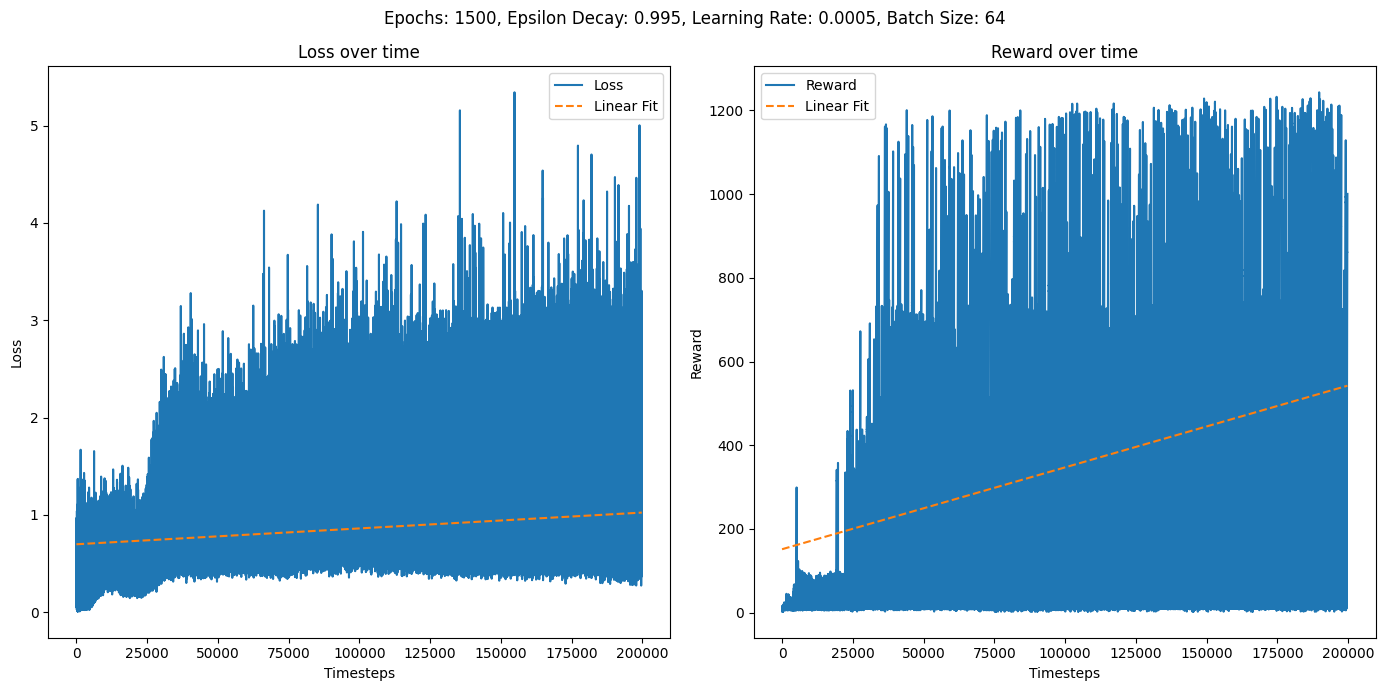

In [10]:
# Reading data from CSV files
loss_df = pd.read_csv(folder_path+'/loss.csv')
reward_df = pd.read_csv(folder_path+'/reward.csv')

# Preparing data for linear regression
timesteps_loss = np.arange(len(loss_df['episode'])).reshape(-1, 1)
loss_values = loss_df['loss'].values

timesteps_reward = np.arange(len(reward_df['episode'])).reshape(-1, 1)
reward_values = reward_df['reward'].values

# Linear regression for loss
loss_model = LinearRegression()
loss_model.fit(timesteps_loss, loss_values)
loss_pred = loss_model.predict(timesteps_loss)

# Linear regression for reward
reward_model = LinearRegression()
reward_model.fit(timesteps_reward, reward_values)
reward_pred = reward_model.predict(timesteps_reward)

# Acutal Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle(f'Epochs: {episodes}, Epsilon Decay: {epsilon_decay}, Learning Rate: {learning_rate}, Batch Size: {batch_size}')

# Plot 1: Loss over time
axs[0].plot(range(len(loss_df['episode'])), loss_df['loss'], label='Loss')
axs[0].plot(range(len(loss_df['episode'])), loss_pred, label='Linear Fit', linestyle='--')
axs[0].set_xlabel('Timesteps')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss over time')
axs[0].legend()

# Plot 2: Reward over time
axs[1].plot(range(len(reward_df['episode'])), reward_df['reward'], label='Reward')
axs[1].plot(range(len(reward_df['episode'])), reward_pred, label='Linear Fit', linestyle='--')
axs[1].set_xlabel('Timesteps')
axs[1].set_ylabel('Reward')
axs[1].set_title('Reward over time')
axs[1].legend()

# Saving the plot
plt.savefig(folder_path+'/loss_reward.png')
plt.tight_layout()
plt.show()

In [11]:
# def testing(env, agent, seed):
#     state, info = env.reset(seed=seed)
#     env = gym.wrappers.RecordVideo(env=env, video_folder="../Videos", video_length=0)

#     init_state = process_state_image(state)

#     state_frame_stack_queue = deque([init_state] * agent.frame_stack_num, maxlen=agent.frame_stack_num)
#     total_reward = 0

#     while True:
#         current_state_frame_stack = generate_state_frame_stack_from_queue(state_frame_stack_queue)
#         action = agent.act(current_state_frame_stack)

#         reward = 0
#         for _ in range(frame_stack_num-1):
#             next_state, r, terminated, truncated, info = env.step(action)
#             if terminated or truncated:
#                 done = True
#             else:
#                 done = False
#             reward += r
#             if done:
#                 break

#         total_reward += reward

#         next_state = process_state_image(next_state)
#         state_frame_stack_queue.append(next_state)

#         if done:
#             break

#     print(f"Total reward after playing the game once: {total_reward}")
#     env.close()
#     return total_reward

In [12]:
# # Load the model for testing
# agent.load('trained_model.pth')
# testing(env, agent, seed)